In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [30]:
from distgen.reader import reader
from distgen.writers import get_writer
from distgen.generator import generator
from distgen.drivers import run_distgen
from distgen.plot import *

In [20]:
# Basic Example using a json file:
# The distgen reader assumes the input file is json formatted.  If not it, it defaults to parsing the file as an ascii txt file.
filename = "rad.gaussian.in.json"
par = reader(filename,verbose=1)
p = par.read()

Reading file 'rad.gaussian.in.json'...done. Time Ellapsed: 755.07 microsecond


In [21]:
dict(p)

{'beam': {'start_type': 'cathode',
  'rand_type': 'hammersley',
  'particle_count': 200000,
  'params': {'total_charge': {'value': 10, 'units': 'pC'},
   'MTE': {'value': 150, 'units': 'meV'}}},
 'r_dist': {'type': 'radial_gaussian',
  'params': {'sigma_xy': {'value': 2, 'units': 'mm'}}},
 't_dist': {'type': 'uniform',
  'params': {'min_t': {'value': -2, 'units': 'ps'},
   'max_t': {'value': 2, 'units': 'ps'}}},
 'output': {'type': 'gpt', 'file': 'rad.gaussian.out.txt'}}

In [22]:
# Generator is the main object that creates a beam distribution
gen = generator(verbose=1) # Create a generator object
gen.parse_input(p)         # Parse input structure
beam,outfile = gen.get_beam() # Generate distribution, return the beam and the desired outputfile
beam.print_stats()

Distribution format: gpt
Output file: rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode.
   Total charge: 10.000 pC.
   Number of macroparticles: 200000.
   r distribution: radial Gaussian
      sigma_xy = 2.000 mm
      Assuming cylindrical symmetry...
   t distribution: uniform
      min_t = -2.000 ps, max_t = 2.000 ps
   px distribution: Gaussian
      avg_px = 0.000 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0.000 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0.000 eV/c, sigma_pz = 276.857 eV/c
   Cathode start: fixing pz momenta to forward hemisphere
      avg_pz -> 220.907 eV/c, sigma_pz -> 166.884 eV/c
...done. Time Ellapsed: 333.86 millisecond.

Beam stats:
   avg_x = 0.000 mm, sigma_x = 2.000 mm
   avg_y = 0.000 mm, sigma_y = 2.000 mm
   avg_z = 0.000 m, sigma_z = 0.000 m
   avg_px = 0.000 eV/c, sigma_px = 276.857 eV/c
   avg_py = 0.000 eV/c, sigma_py = 276.857 eV/c
   avg_pz = 220.907

In [6]:
# The beam object allows access to the beam coordinates via [...]
x = beam["x"]
print(x)

[0.7186822  2.57194233 1.73155953 ... 2.84179025 1.97398743 4.1643154 ] millimeter


In [7]:
# The bunch charge is given by beam.q
beam.q

10 <Unit('picocoulomb')>

In [40]:
# The distgen writer is used to write the beam to files for different codes (GPT,ASTRA)
gpt_writer =  get_writer("gpt","rad.gaussian.gpt.out.txt")
gpt_writer.write(beam,verbose=1,params=p)


Printing 200000 particles to 'rad.gaussian.gpt.out.txt': ...done. Time ellapsed: 1.72 second.


In [41]:
astra_writer = get_writer("astra","rad.gaussian.astra.out.txt")
astra_writer.write(beam,verbose=1)


Printing 200000 particles to 'rad.gaussian.astra.out.txt': ...done. Time ellapsed: 1.57 second.


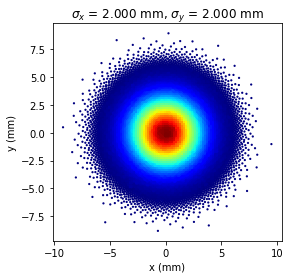

In [10]:
# The distgen module has some basic plotting routines
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

units = {"x":"mm","y":"mm","px":"keV/c","py":"keV/c","t":"ps","q":"pC"}

# plot_2d allows for plotting a 2D subspace of the beam coordinates:

fig=plt.figure(1)
# X-Y Plot
plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal");

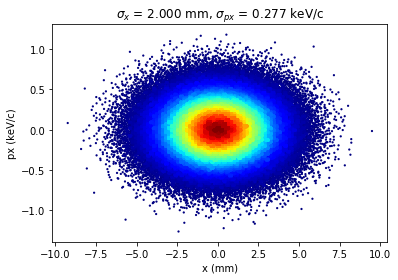

In [11]:
# X-Px Plot
fig.add_subplot(1,3,2)
plot_2d(beam,1,"x",units["x"],"px",units["px"],'scatter_hist2d',nbins=100);

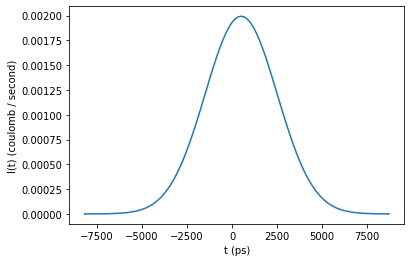

In [19]:
# Laser Current Profile
plot_current_profile(beam,1,units);

In [37]:
#********************************************************************************
# User the driver function
#********************************************************************************

# All of the above commands can be executed together in one call using the driver
# function run_distgen:

beam = run_distgen(inputs=p,output_type="gpt",verbose=1)

**************************************************
                Dist Generator v 1.0
**************************************************
Distribution format: gpt
Output file: rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode.
   Total charge: 10.000 pC.
   Number of macroparticles: 200000.
   r distribution: radial Gaussian
      sigma_xy = 2.000 mm
      Assuming cylindrical symmetry...
   t distribution: uniform
      min_t = -2.000 ps, max_t = 2.000 ps
   px distribution: Gaussian
      avg_px = 0.000 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0.000 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0.000 eV/c, sigma_pz = 276.857 eV/c
   Cathode start: fixing pz momenta to forward hemisphere
      avg_pz -> 220.907 eV/c, sigma_pz -> 166.884 eV/c
...done. Time Ellapsed: 330.28 millisecond.

Beam stats:
   avg_x = 0.000 mm, sigma_x = 2.000 mm
   avg_y = 0.000 mm, sigma_y = 2.000 mm
   avg_z = 0.0

In [38]:
# Note, the keyword arguement 'inputs' can also take the file name:
beam = run_distgen(inputs="rad.gaussian.in.json",output_type="gpt",verbose=1)

**************************************************
                Dist Generator v 1.0
**************************************************
Reading file 'rad.gaussian.in.json'...done. Time Ellapsed: 576.02 microsecond
Distribution format: gpt
Output file: rad.gaussian.out.txt

Creating beam distribution....
   Beam starting from: cathode.
   Total charge: 10.000 pC.
   Number of macroparticles: 200000.
   r distribution: radial Gaussian
      sigma_xy = 2.000 mm
      Assuming cylindrical symmetry...
   t distribution: uniform
      min_t = -2.000 ps, max_t = 2.000 ps
   px distribution: Gaussian
      avg_px = 0.000 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0.000 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0.000 eV/c, sigma_pz = 276.857 eV/c
   Cathode start: fixing pz momenta to forward hemisphere
      avg_pz -> 220.907 eV/c, sigma_pz -> 166.884 eV/c
...done. Time Ellapsed: 326.19 millisecond.

Beam stats:
   avg_x = 0.000

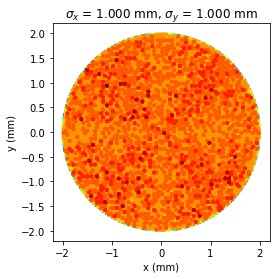

In [16]:
#********************************************************************************
# Shifting/Scaling Coordinates:
#********************************************************************************
 
# The distgen module allows the user shift and scale beam coordinate
# by adding avg_{variable} and sigma_{variable} parameters to beam params in the input dictionary:

# Load radially uniform example:
par.reset("rad.uniform.in.json",verbose=0)
p = par.read()

# The example makes a doughnut, let's make it a solid circle by setting min_r = 0
p["r_dist"]["params"]["min_r"]["value"]=0

gen.verbose=0
gen.parse_input(p)
beam,outfile = gen.get_beam()

plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal");

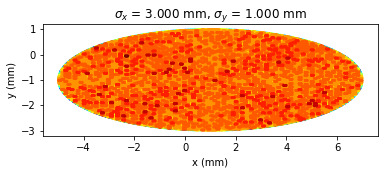

In [17]:
# Now, add the x,y offsets and re-scale x:
p["beam"]["params"]["avg_x"]={"value":1,"units":"mm"}
p["beam"]["params"]["avg_y"]={"value":-1,"units":"mm"}
p["beam"]["params"]["sigma_x"]={"value":3,"units":"mm"}

gen.parse_input(p)
beam,outfile = gen.get_beam()

plot_2d(beam,1,"x",units["x"],"y",units["y"],'scatter_hist2d',nbins=100,axis="equal");